# Analyzing card layout with custom model

1. Define problem, annotation scheme, and target
2. Split labeled data to train/test, train custom layout model
3. Predict bounding boxes with custom model (DIA)
4. Extract text inside bounding boxes with Tesseract (OCR)
5. Structure output and extract entities from structured data (NER)

To do:
- [x] put scans on Great Lakes Turbo (`/nfs/turbo/isr-jtalexnonsen/images`)
- [x] tune layout model so that each bounding box is one text field
- [x] set up Tesseract-OCR engine on Great Lakes
- [x] add labels to annotations based on region of card for structured data


What to run and how:

- Local: label cards with Label Studio
- Great Lakes virtual desktop or terminal: model training with Detectron2; bounding box delineation with Layout Parser; text extraction with Tesseract OCR
- Great Lakes On Demand Jupyter notebooks: visual inspection of model with Layout Parser

Module installation: install layoutparser, torchvision, detectron pretrained models, and OCR utility

```
module load gcc/8.2.0
module load python3.8-anaconda/2020.07
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2" --user
!pip install layoutparser[ocr] --user
```

Module activation: activate project virtual environment (``layout_parser``) and modules (`restore module tesseract`)

```
module purge
conda deactivate
module use /sw/examples/pytorch/modules
module load gcc/8.2.0 image-libraries
module load python/3.9.7 cuda/11.3.0 pytorch/1.10.2
cd $HOME
source layout_parser/bin/activate
```

In [1]:
import layoutparser as lp
import pandas as pd
import numpy as np
import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from pycocotools.coco import COCO

plt.rcParams["figure.figsize"] = (20,30)

## 1. Define problem, annotation scheme, and target

Load a sample image from Turbo. Options:
- all, nested hierarchy (`/nfs/turbo/isr-jtalexnonsen/images`)
    - images included in training set (`/nfs/turbo/isr-jtalexnonsen/images/783095-01`); n=1,224
    - images not included in training set (`/nfs/turbo/isr-jtalexnonsen/images/783095-02`); n=1,207
- all, flattened hierarchy (`/nfs/turbo/isr-jtalexnonsen/flat_images`)
- sample scans labeled for training data (`/nfs/turbo/isr-jtalexnonsen/sample_scans`)

Problem: pretrained models are not optimized for this kind of index card layout. Bounding boxes collide when using [PrimaLayout](https://www.primaresearch.org/dataset/) pretrained model for magazine pages from LayoutParser Model Zoo.

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/home/slafia/.local/lib/python3.8/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/slafia/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-de

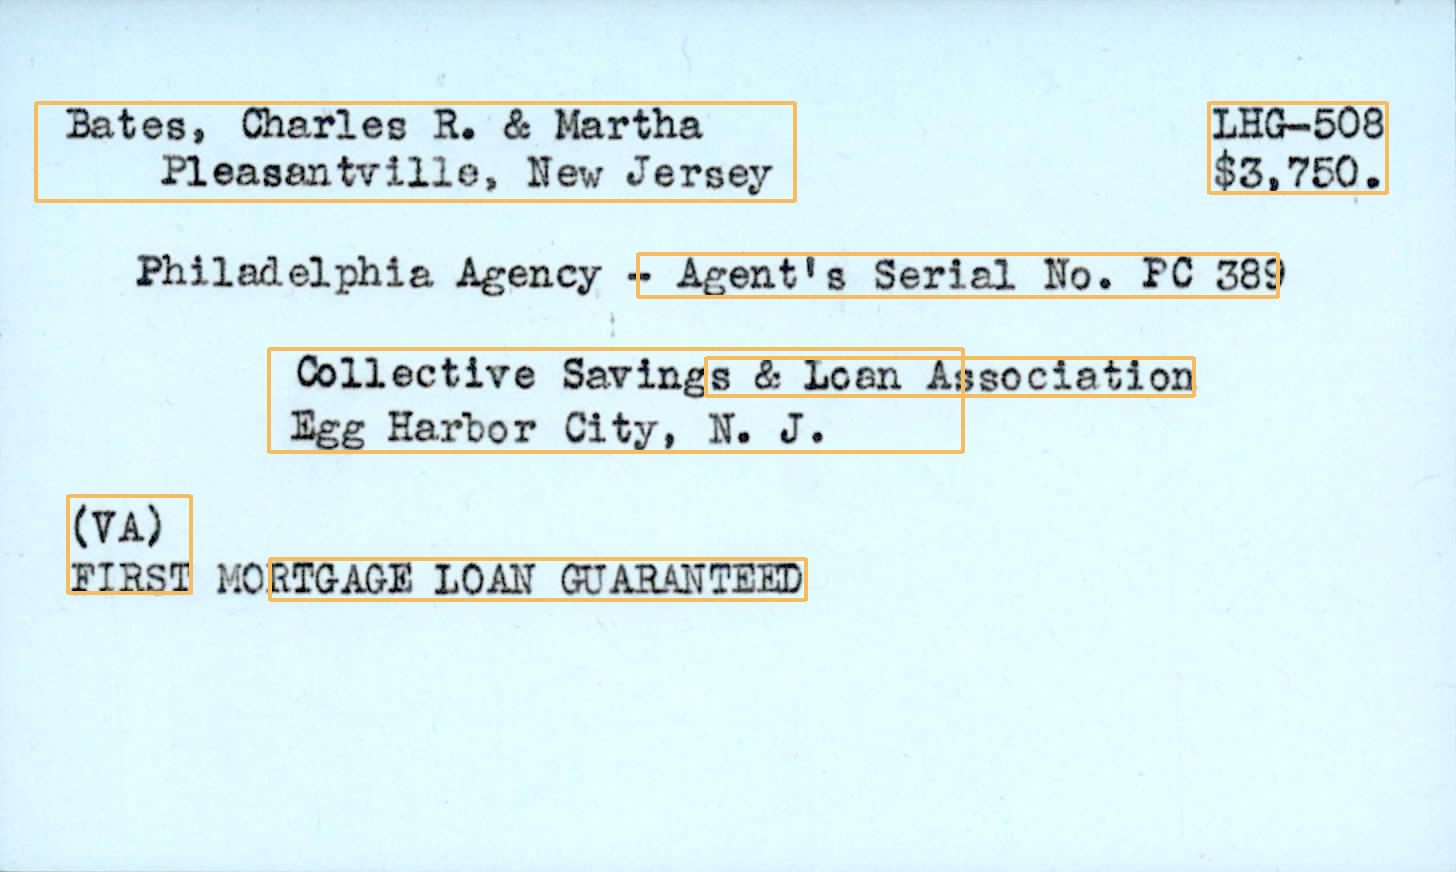

In [2]:
image_files = sorted(glob.glob('/nfs/turbo/isr-jtalexnonsen/images/783095-02'+'/*.jpg'))
rand_select = random.choice(image_files)
print("Card selected: ", rand_select)
sample_image = cv2.imread(rand_select)
model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8])
layout_result = model.detect(sample_image)
lp.draw_box(sample_image, layout_result)

Approach: label N cards in Label Studio and tune PrimaLayout model with Detectron2 library

Annotation scheme:

- `NAME` of mortgagee ("Aaron, Samuel H. and Pearl C.")
- `LOCATION` of mortgageee ("Wichita, Kansas")
- `ID` of mortgage ("LHG-10124")
- `AMOUNT` of mortgage ("$9,000. CC-64")
- `AGENCY` issuing mortgage ("Kansas City Agency The Reserve Building & Loan Association Wichita, Kansas)
- `STATUS` of mortgage ("(VA) FIRST MORTGAGE LOAN GUARANTEED")

Labeling guidelines:

- snap boxes to text and limit whitespace
- if fields are reordered, include and handle in text post-processing

Target:

- label data until reaching average precision (AP) > 0.8 per category

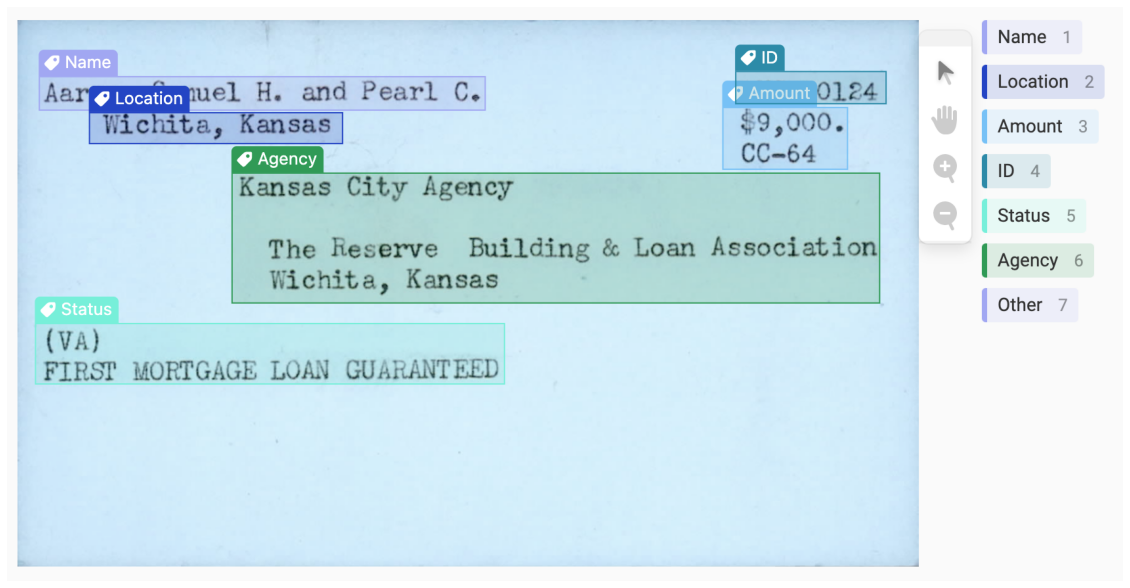

In [3]:
labeled_image = cv2.imread('../example-boxes.png') # example image from Label Studio including annotation scheme
plt.axis('off')
plt.imshow(labeled_image);

Load data annotated with Label Studio and check that it's rendered correctly. If so, train/test split and train a custom model in a terminal. Train model with a SGPU machine w/12+ GB of RAM. ~500 examples takes about 5 hrs (for labeling data and training a model).

```
python cocosplit.py --annotation-path ../data/cards-v2/result.json --split-ratio 0.8 --train ../data/cards-v2/train.json --test ../data/cards-v2/test.json
```

In [4]:
def load_coco_annotations(annotations, coco=None):
    layout = lp.Layout()
    for ele in annotations:
        x, y, w, h = ele['bbox']
        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )
    return layout

COCO_ANNO_PATH = '../layout-model-training/data/cards-v4/result.json'
COCO_IMG_PATH = '../layout-model-training/data/cards-v4/images/7'

coco = COCO(COCO_ANNO_PATH)

# for image_id in random.sample(coco.imgs.keys(), 1):
#     image_info = os.path.basename(str(coco.imgs[image_id]['file_name']))
#     annotations = coco.loadAnns(coco.getAnnIds([image_id]))
    
#     image = cv2.imread(f'{COCO_IMG_PATH}/{image_info}')
#     print(f'{COCO_IMG_PATH}/{image_info}')
#     layout = load_coco_annotations(annotations, coco)
    
#     viz = lp.draw_box(image, layout)
#     display(viz)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## 3. Predict bounding boxes with custom model (DIA)

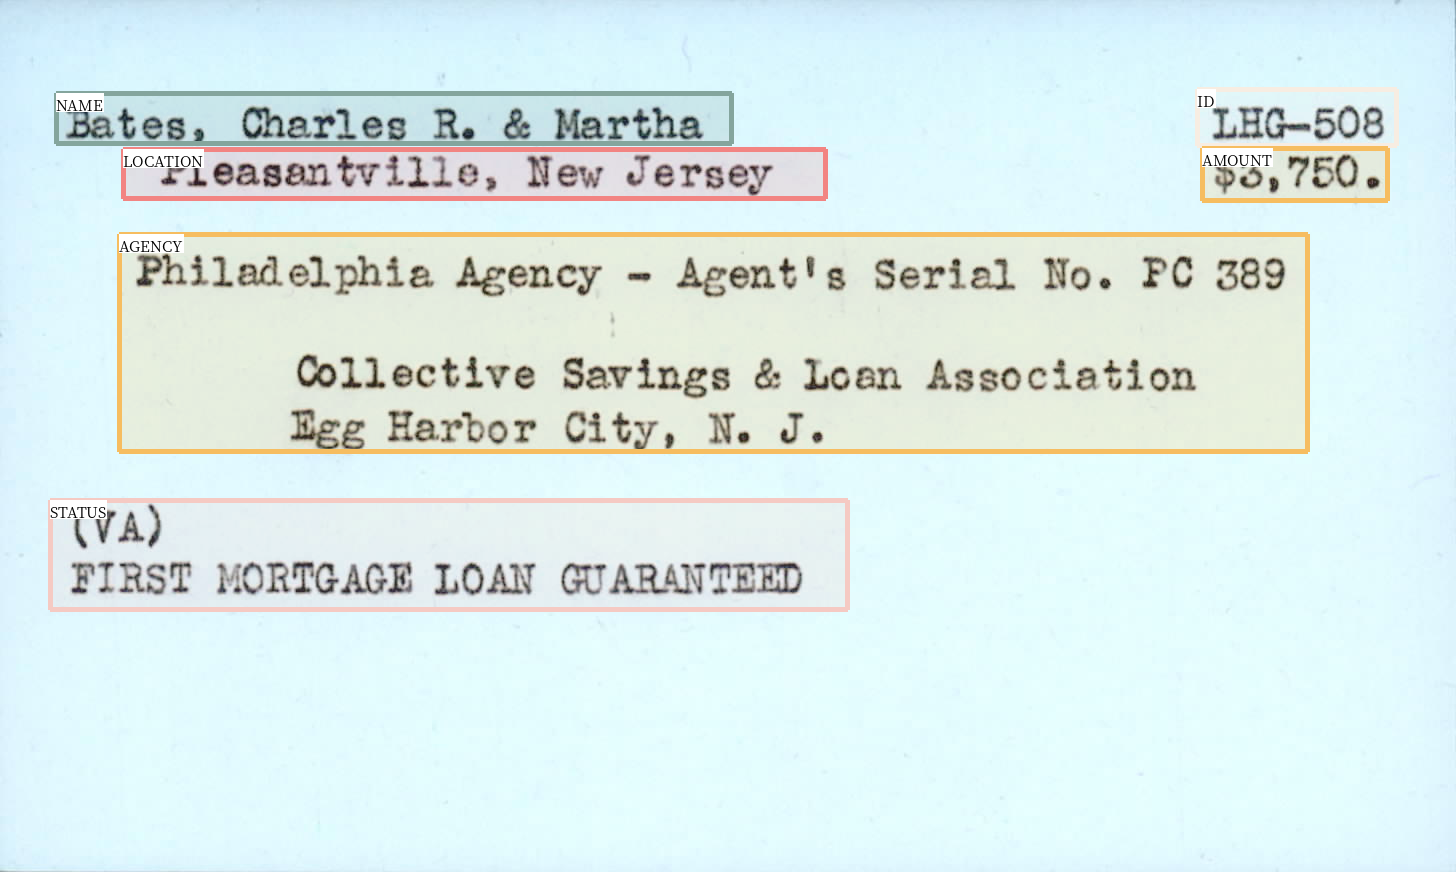

In [5]:
custom_model = lp.Detectron2LayoutModel(
    config_path = "../layout-model-training/outputs/cards-v4/fast_rcnn_R_50_FPN_3x/config.yaml", # custom model configuration
    model_path = "../layout-model-training/outputs/cards-v4/fast_rcnn_R_50_FPN_3x/model_final.pth", # custom model trained on Great Lakes
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8], # optional: confidence threshold for bounding boxes of detected layout
    label_map={0: "AGENCY", 1: "AMOUNT", 2: "ID", 3:"LOCATION", 4:"NAME", 5:"OTHER", 6:"STATUS"} # optional: mapping from label codes to categories
)

custom_layout = custom_model.detect(sample_image)
lp.draw_box(sample_image, custom_layout, box_width=5, box_alpha=0.2, show_element_type=True) # adjust box display settings

Return information about custom layout

In [6]:
text_blocks = lp.Layout([b for b in custom_layout])
image_width = len(sample_image[0])
left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(sample_image)
left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks
left_blocks.sort(key = lambda b:b.coordinates[1])
right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])
print(f"{len(text_blocks)} text blocks detected.")

6 text blocks detected.
